# Loading and Data Preparation:


In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import ConfusionMatrix


In [3]:
# Function for setting the seed
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/test.csv')
sample_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/sample_submission.csv')

## Split lables and features

In [6]:
# Separate the dataset into features (pixel values) and labels
labels = train_data['label']
pixels = train_data.drop('label', axis=1) / 255.0  # Normalize pixel values

# Check shapes
print("Check shapes:", labels.shape, pixels.shape)

# Get unique class names, assuming labels are stored as integers or categorical data
class_names = sorted(labels.unique())

# Print the class names
print("Class Names:", class_names)

Check shapes: (42000,) (42000, 784)
Class Names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Split train and val datasets, reshape the pixel values into the appropriate format for a CNN.

In [7]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1, 1, 28, 28)
X_val = np.array(X_val).reshape(-1, 1, 28, 28)

# Define a simple CNN model


    
   

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()


In [9]:
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values if isinstance(y_train, pd.Series) else y_train, dtype=torch.long)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val.values if isinstance(X_val, pd.DataFrame) else X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values if isinstance(y_val, pd.Series) else y_val, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Output to confirm loaders are created
print("Train and validation loaders created:")
print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))

Train and validation loaders created:
Train loader size: 525
Validation loader size: 132


# Define the model, loss function, and optimizer

In [10]:
# simple NN model
model = SimpleCNN()
print(model)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# custom accuracy
def accuracy_fn(y_true, y_pred):
    return MulticlassAccuracy(num_classes=len(class_names))(preds=y_pred, target=y_true)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#   Train the model

In [11]:
# Check if CUDA (GPU support) is available and choose the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
import torch
import numpy as np
import torchmetrics

def evaluate_confusion_matrix(model, dataloader, device):
    model.eval()
    model.to(device)  # Ensure the model is moved to the right device
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
            outputs = model(inputs)

            # Convert outputs to probabilities and determine predicted class
            probabilities = torch.softmax(outputs, dim=1)
            predictions = probabilities.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Convert lists to tensors
    y_true_tensor = torch.tensor(y_true)
    y_pred_tensor = torch.tensor(y_pred)

    # Calculate confusion matrix
    confusion_matrix = torchmetrics.functional.confusion_matrix(
        preds=y_pred_tensor,
        target=y_true_tensor,
        num_classes=10,
        task='multiclass'
    )
    return confusion_matrix

# Calculate confusion matrices
train_confusion_matrix = evaluate_confusion_matrix(model, train_loader, device)
val_confusion_matrix = evaluate_confusion_matrix(model, val_loader, device)

# Print confusion matrices
print("Train Confusion Matrix:")
print(train_confusion_matrix)

print("\nVal Confusion Matrix:")
print(val_confusion_matrix)


Train Confusion Matrix:
tensor([[   0,    0,    0,    0,    0,    2,  848,    0, 1814,  652],
        [   0,    0,    0,    0,    0,   78, 2281,    0,  532,  884],
        [   7,    0,    0,    0,    0,   31, 1091,    2, 1942,  258],
        [  10,    0,    0,    0,    0,   38,  442,    1, 2764,  159],
        [  18,    0,    0,    0,    0,    7, 2156,    0,  894,  158],
        [   3,    0,    0,    0,    0,    2,  545,    4, 1944,  595],
        [   2,    0,    0,    0,    0,   10, 1142,    0, 2118,   80],
        [   6,    0,    0,    0,    0,    5, 1747,    0,  445, 1305],
        [   1,    0,    0,    0,    0,    0,  804,    2, 2173,  248],
        [   8,    0,    0,    0,    0,    3, 2327,    1,  801,  210]])

Val Confusion Matrix:
tensor([[  1,   0,   0,   0,   0,   0, 228,   0, 441, 146],
        [  1,   0,   0,   0,   0,  17, 570,   0, 119, 202],
        [  1,   0,   0,   0,   0,   4, 247,   1, 524,  69],
        [  4,   0,   0,   0,   0,   4, 120,   0, 766,  43],
        [  3

In [13]:
import torch
import numpy as np
import torchmetrics

def evaluate_confusion_matrix(model, dataloader, device):
    model.eval()
    model.to(device)  # Ensure the model is moved to the right device
    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
            outputs = model(inputs)

            # Convert outputs to probabilities
            probabilities = torch.softmax(outputs, dim=1)

            # Get the class with the highest probability
            _, predictions = torch.max(probabilities, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Convert arrays to tensors for confusion matrix calculation
    y_true_tensor = torch.tensor(y_true).to(device)
    y_pred_probs_tensor = torch.tensor(y_pred_probs).argmax(axis=1).to(device)  # Use argmax to get the predicted class indices

    # Calculate confusion matrix
    confusion_matrix = torchmetrics.functional.confusion_matrix(preds=y_pred_probs_tensor, target=y_true_tensor,   task='multiclass', num_classes=10)
    return confusion_matrix

# Calculate confusion matrices
train_confusion_matrix = evaluate_confusion_matrix(model, train_loader, device)
val_confusion_matrix = evaluate_confusion_matrix(model, val_loader, device)

# Print confusion matrices
print("Train Confusion Matrix:")
print(train_confusion_matrix)

print("\nVal Confusion Matrix:")
print(val_confusion_matrix)


Train Confusion Matrix:
tensor([[   0,    0,    0,    0,    0,    2,  848,    0, 1814,  652],
        [   0,    0,    0,    0,    0,   78, 2281,    0,  532,  884],
        [   7,    0,    0,    0,    0,   31, 1091,    2, 1942,  258],
        [  10,    0,    0,    0,    0,   38,  442,    1, 2764,  159],
        [  18,    0,    0,    0,    0,    7, 2156,    0,  894,  158],
        [   3,    0,    0,    0,    0,    2,  545,    4, 1944,  595],
        [   2,    0,    0,    0,    0,   10, 1142,    0, 2118,   80],
        [   6,    0,    0,    0,    0,    5, 1747,    0,  445, 1305],
        [   1,    0,    0,    0,    0,    0,  804,    2, 2173,  248],
        [   8,    0,    0,    0,    0,    3, 2327,    1,  801,  210]])

Val Confusion Matrix:
tensor([[  1,   0,   0,   0,   0,   0, 228,   0, 441, 146],
        [  1,   0,   0,   0,   0,  17, 570,   0, 119, 202],
        [  1,   0,   0,   0,   0,   4, 247,   1, 524,  69],
        [  4,   0,   0,   0,   0,   4, 120,   0, 766,  43],
        [  3

In [14]:
# Move the model to the GPU (if CUDA is available)
model.to(device)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    Evaluate the model on the test set to assess its performance.

In [15]:

model.to(device)
model.eval()

with torch.no_grad():
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)  # Move validation data to the device
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)  # Move validation labels to the device
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)  # Ensure inputs are on the same device as the model
        labels = labels.to(device)  # Ensure labels are on the same device as the model
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 98.06%


Test Accuracy: 98.52%

Prepare the Test Data:
Similar to how you prepared your training and validation datasets, you need to prepare your test dataset. Load the test data and preprocess it accordingly.

In [16]:
# Same preprocessing as the train
X_test = test_data.values / 255.0
X_test = X_test.reshape(-1, 1, 28, 28)  # Corrected line

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Assuming y_test_tensor contains the true labels
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)


In [17]:
pred_probs = []
model.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # Move input tensor to GPU

        # Move the model to the GPU
        model = model.to(device)

        # Forward pass (model outputs raw logit)
        pred_logit = model(inputs)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit, dim=1)

        # Append the prediction probabilities to the list
        pred_probs.append(pred_prob.cpu().numpy())

# Convert the list of prediction probabilities to a NumPy array
pred_probs_array = np.concatenate(pred_probs, axis=0)


In [18]:
pred_probs_array

array([[2.0426488e-10, 5.7920675e-14, 1.0000000e+00, ..., 3.1591110e-09,
        5.1403659e-09, 1.4854010e-12],
       [9.9999368e-01, 2.9023417e-09, 2.7342157e-09, ..., 1.3966661e-07,
        1.9604499e-10, 6.2262153e-12],
       [1.0890915e-11, 8.2175944e-10, 2.3083737e-06, ..., 5.5197876e-07,
        2.3360208e-06, 9.9997652e-01],
       ...,
       [6.3583805e-22, 2.7417838e-17, 2.1743247e-15, ..., 2.6779260e-15,
        2.0254649e-11, 1.3117823e-12],
       [3.8393566e-10, 6.8603538e-13, 8.3541241e-10, ..., 3.8689552e-05,
        7.3330177e-08, 9.9876827e-01],
       [2.0991789e-12, 8.8569450e-15, 1.0000000e+00, ..., 2.0393165e-10,
        2.4617735e-09, 1.3439562e-12]], dtype=float32)

In [19]:
predicted_labels = np.argmax(pred_probs_array, axis=1)
predicted_labels

array([2, 0, 9, ..., 3, 9, 2])

In [20]:
sample_data

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [21]:
sample_data['Label'] = predicted_labels
sample_data

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [22]:
sample_data.to_csv('/content/drive/MyDrive/Digit_recogn/sample_submission_digit.csv', index=False)

**rank 1036/1833**

https://www.kaggle.com/competitions/digit-recognizer/submissions


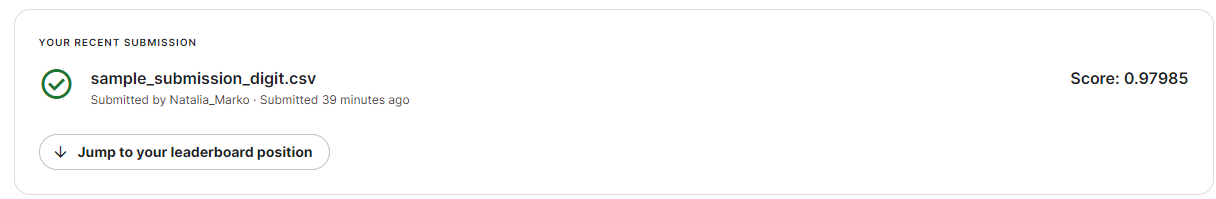